=== Baseline Logistic Regression (ALT > 40) ===
Test Accuracy : 0.907
Test F1       : 0.596
Test AUROC    : 0.963
Class balance (train) — positives: 0.078, test: 0.078


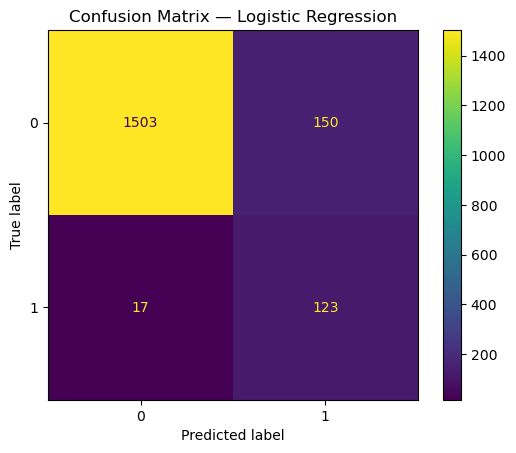

Saved: /Users/rishansujesh/Downloads/nhanes_liver/images/confusion_matrix.png


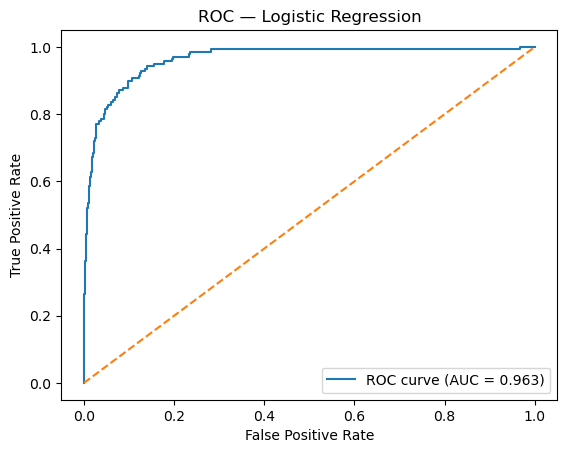

Saved: /Users/rishansujesh/Downloads/nhanes_liver/images/roc_curve.png


In [2]:
# ---- Baseline: Logistic Regression on ALT>40 --------------------------------
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    ConfusionMatrixDisplay, roc_curve, auc
)

# Paths
ROOT = Path(".").resolve()
DATA = ROOT / "nhanes_cleaned.csv"
IMG_DIR = ROOT / "images"
IMG_DIR.mkdir(exist_ok=True)

# Load
df = pd.read_csv(DATA, low_memory=False)

# Target handling
if "elevated_alt" not in df.columns:
    raise ValueError("elevated_alt not found. Re-run 00_clean_dataset.py first.")
# Drop rows with missing ALT label
df = df.dropna(subset=["elevated_alt"]).copy()
df["elevated_alt"] = df["elevated_alt"].astype(int)

# Features/target
y = df["elevated_alt"]
X = df.drop(columns=["elevated_alt", "LBXSATSI", "SEQN"], errors="ignore")  # remove raw ALT + ID

# Choose categorical vs numeric explicitly (robust to missing optional columns)
categorical_cols = [c for c in [
    "RIAGENDR", "RIDRETH1", "DMDEDUC2", "DMDMARTZ",
    # optional categoricals if present
    "SDDSRVYR", "DMDBORN4", "RIDEXMON"
] if c in X.columns]

# Everything else numeric by default
numeric_cols = [c for c in X.columns if c not in categorical_cols]

# Pipelines
numeric_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, numeric_cols),
        ("cat", categorical_pipe, categorical_cols)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# Model (balanced helps when positives are less common)
clf = LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=None)

pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", clf)
])

# Split (stratified so class ratio stays consistent)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# Fit
pipe.fit(X_train, y_train)

# Predict / Metrics
y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred, zero_division=0)
roc = roc_auc_score(y_test, y_prob)

print("=== Baseline Logistic Regression (ALT > 40) ===")
print(f"Test Accuracy : {acc:.3f}")
print(f"Test F1       : {f1:.3f}")
print(f"Test AUROC    : {roc:.3f}")
print(f"Class balance (train) — positives: {y_train.mean():.3f}, test: {y_test.mean():.3f}")

# Confusion Matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.ax_.set_title("Confusion Matrix — Logistic Regression")
cm_path = IMG_DIR / "confusion_matrix.png"
plt.savefig(cm_path, bbox_inches="tight", dpi=144)
plt.show()
print(f"Saved: {cm_path}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC — Logistic Regression")
plt.legend(loc="lower right")
roc_path = IMG_DIR / "roc_curve.png"
plt.savefig(roc_path, bbox_inches="tight", dpi=144)
plt.show()
print(f"Saved: {roc_path}")


Best threshold for F1: 0.787  |  F1: 0.735  |  Precision: 0.701  |  Recall: 0.771


Saved tuned confusion matrix to: images/confusion_matrix_tuned.png


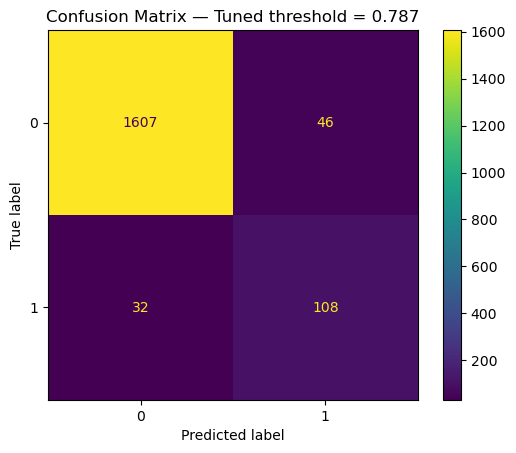

In [4]:
from sklearn.metrics import precision_recall_curve, f1_score, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import os

# Reuse y_test and y_prob from the previous cell
prec, rec, th = precision_recall_curve(y_test, y_prob)
f1s = 2 * prec * rec / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1s)
best_th = th[best_idx]
best_f1 = f1s[best_idx]

print(f"Best threshold for F1: {best_th:.3f}  |  F1: {best_f1:.3f}  |  Precision: {prec[best_idx]:.3f}  |  Recall: {rec[best_idx]:.3f}")

# Make tuned predictions
y_pred_tuned = (y_prob >= best_th).astype(int)

# Create and display the confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_tuned)
plt.title(f"Confusion Matrix — Tuned threshold = {best_th:.3f}")

# Ensure the images folder exists
os.makedirs("images", exist_ok=True)

# Save the plot
save_path = os.path.join("images", "confusion_matrix_tuned.png")
plt.savefig(save_path, bbox_inches="tight", dpi=300)
print(f"Saved tuned confusion matrix to: {save_path}")

# Show the plot
plt.show()
